In [1]:
import sys 
import os
import cymetric as cym
import pandas as pd
import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm
    
%matplotlib inline

In [13]:
# no U232
no_u232 = cym.dbopen('./growthregion/no_u232.sqlite')
ev_no = cym.Evaluator(db=no_u232, write=False)
# yes U232
yes_u232 = cym.dbopen('./growthregion/yes_u232.sqlite')
ev_yes = cym.Evaluator(db=yes_u232, write=False)

In [53]:
def plot_fuel(evaler):
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions = transactions.rename(columns={'TimeCreated':'Time'})

    transactions['non_total'] = transactions.loc[transactions['Commodity'] == 'UOX_NoAdditive']['Quantity'].cumsum()
    transactions['add_total'] = transactions.loc[transactions['Commodity'] == 'UOX_Additive']['Quantity'].cumsum()

    transactions.fillna(method='ffill', inplace=True)
    transactions['total_fuel'] = transactions['non_total'] + transactions['add_total']

    # Plotting cumulative fuel sent to reactors at each time step
    transactions[['Time', 'non_total', 'add_total', 'total_fuel']].plot(x = 'Time', figsize=(12,8), legend=False)
    plt.xlabel('Time (months)',fontsize=18)
    plt.ylabel('Mass of fuel fabricated (kg)',fontsize=18)

    legend = plt.legend()
    legend.get_texts()[0].set_text('UOX without Additive')
    legend.get_texts()[1].set_text('UOX with Additive')
    legend.get_texts()[2].set_text('Total')
    legend.set_title('Fuel Type')

    plt.show()
    return

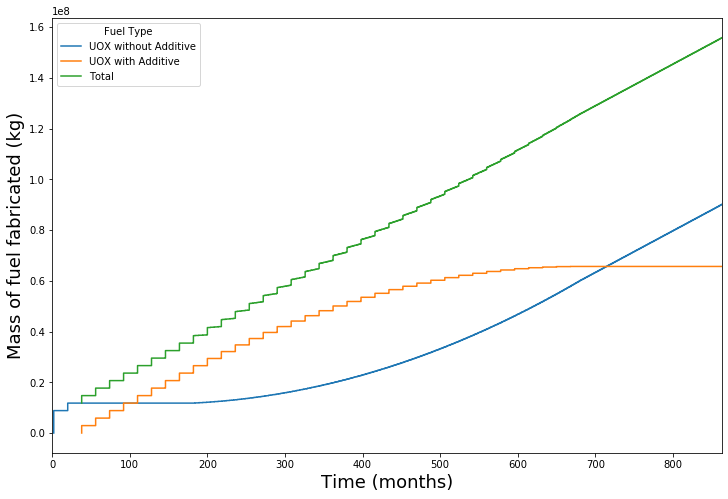

In [61]:
# pref change, separate UOX/Spent UOX commods
db_prf = cym.dbopen('./growthregion/pref_change.sqlite')
ev_prf = cym.Evaluator(db=db_prf, write=False)
#cgr.flow_graph(ev_prf, label='mass')
plot_fuel(ev_prf)

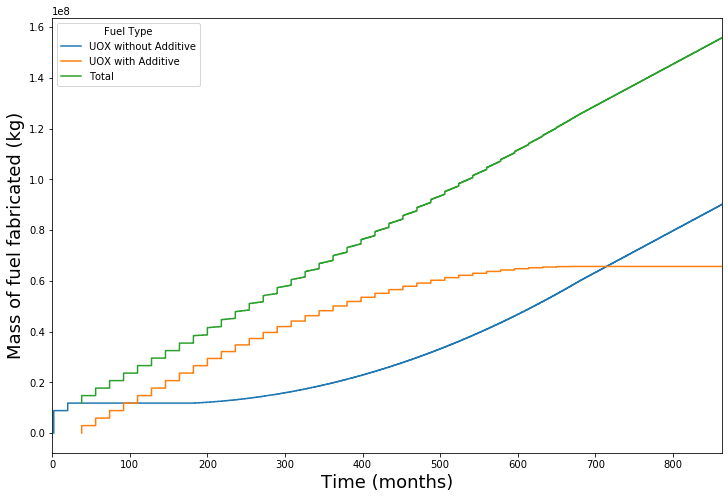

In [58]:
# pref change, separate UOX/Spent UOX commods
db_prf = cym.dbopen('./growthregion/pref_change.sqlite')
ev_prf = cym.Evaluator(db=db_prf, write=False)
#cgr.flow_graph(ev_prf, label='mass')
plot_fuel(ev_prf)

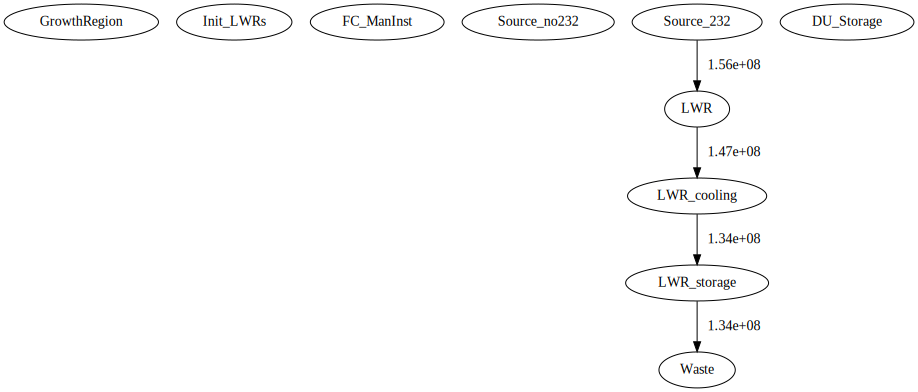

In [13]:
# recipe change, one UOX/Spent UOX commod
db_rec = cym.dbopen('./growthregion/recipe_test.sqlite')
ev_rec = cym.Evaluator(db=db_rec, write=False)
cgr.flow_graph(ev_rec, label='mass')

# Mass Flows

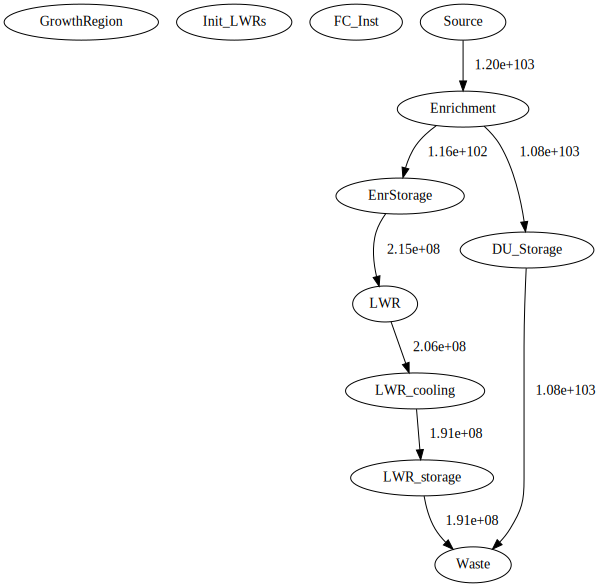

In [14]:
cgr.flow_graph(ev_no, label='mass')

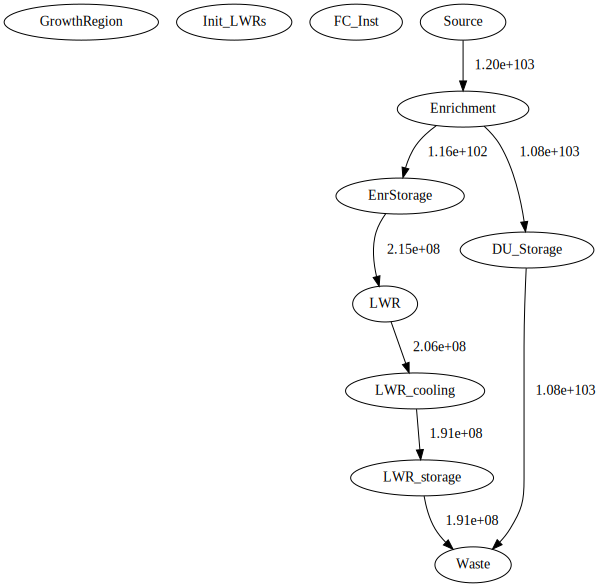

In [15]:
cgr.flow_graph(ev_yes, label='mass')

# Time Series Power (check constant)

In [10]:
df_prf = ev_prf.eval('TimeSeriesPower')
df_rec = ev_rec.eval('TimeSeriesPower')

# power in GWe
power_prf = df_prf.groupby(['Time'])['Value'].sum() / 1000.0
power_rec = df_rec.groupby(['Time'])['Value'].sum() / 1000.0
power = pd.DataFrame({'pref_change_power' : power_prf, 'recipe_change_power' : power_rec}, index=power_prf.index).reset_index()

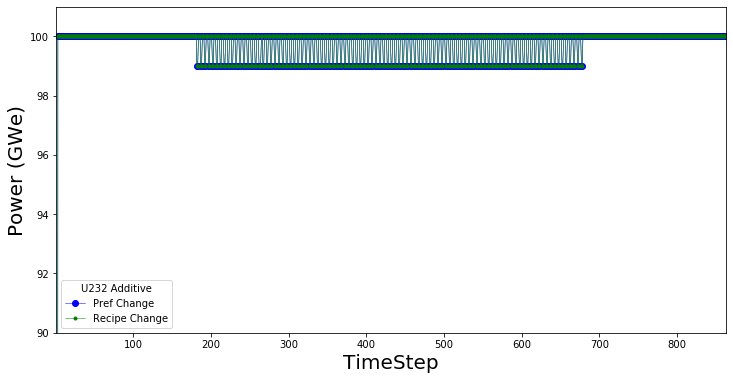

In [11]:
colors = ['green', 'purple']
styles = ['bo-', 'g.-']
ax = power.plot(x='Time', figsize=(12,6), legend=False, style=styles, linewidth=0.5)
legend = plt.legend()
legend.get_texts()[0].set_text('Pref Change')
legend.get_texts()[1].set_text('Recipe Change')
legend.set_title('U232 Additive')
plt.xlabel(r'TimeStep', fontsize=20)
plt.ylabel(r'Power (GWe)',fontsize=20)
ax.set_ylim(90, 101)
plt.show()

# Older

In [15]:
# deploy inst managed
db_deploy = cym.dbopen('./deployinst/cyclus.sqlite')
evd = cym.Evaluator(db=db_deploy, write=False)
# growth region managed
db_growth = cym.dbopen('./growthregion/cyclus.sqlite')
evg = cym.Evaluator(db=db_growth, write=False)
# test growth region 
#db_test = cym.dbopen('./growthregion/test_growth.sqlite')
#evt = cym.Evaluator(db=db_test, write=False)

# Difference in Mass Flows:

Deploy Inst sim a little less material than Growth Region sim

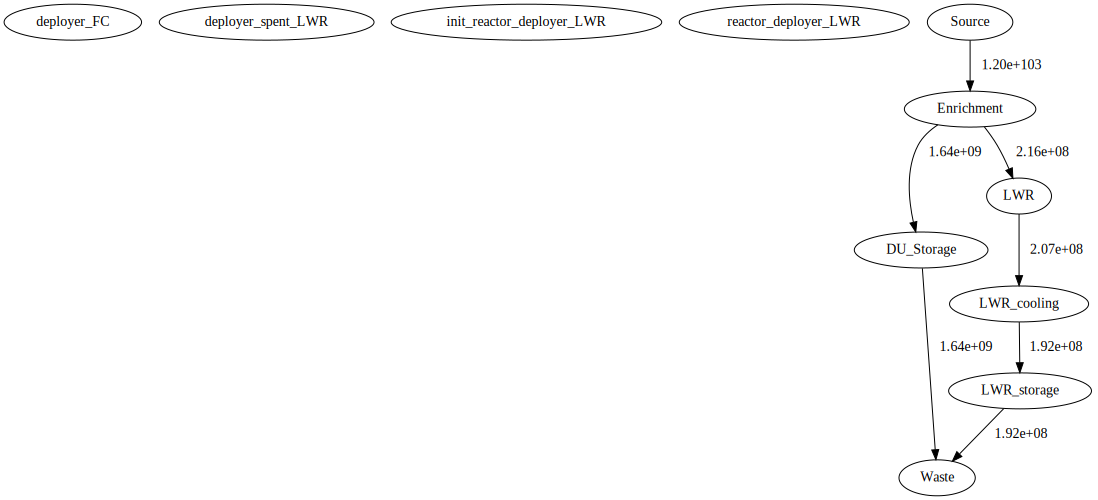

In [16]:
cgr.flow_graph(evd, label='mass')

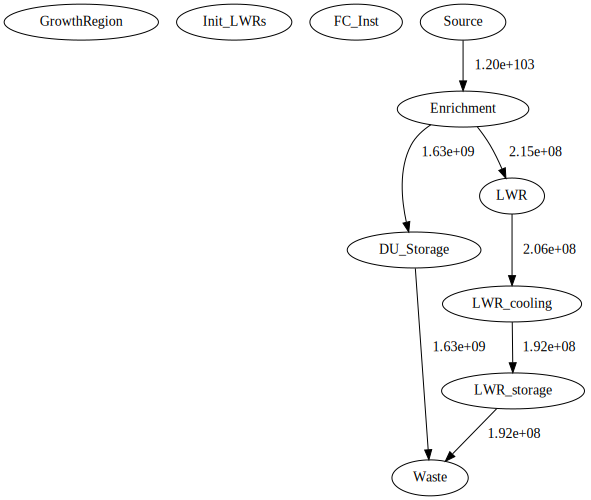

In [17]:
cgr.flow_graph(evg, label='mass')

# Compare the comm decomm (and cumsums) of reactors in each sim (code from cymetric examples)

In [18]:
def rxtr_enter_exit(evaluator):
        
    comm = evaluator.eval('BuildSeries')
    decomm = evaluator.eval('DecommissionSeries')
    time = evaluator.eval('TimeList')

    neg = -decomm['Count']
    decomm = decomm.drop('Count',axis=1)
    decomm = pd.concat([decomm, neg],axis=1)
    
    comm = comm.rename(columns={'EnterTime':'Time'})
    decomm = decomm.rename(columns={'ExitTime':'Time'})
    
    comm = comm.pivot('Time','Prototype')['Count'].reset_index()
    decomm = decomm.pivot('Time','Prototype')['Count'].reset_index()
    comm_decomm = pd.merge(comm, decomm, left_on='Time', right_on='Time', how='outer', sort=True, \
                           suffixes=('_enter', '_exit')).fillna(0)
    comm_decomm.Time = comm_decomm.Time.astype(int)
    
    #add all sim timesteps
    comm_decomm = pd.concat([comm_decomm, time], axis=1).fillna(0)
    #######################(need to join on time)
    
    return comm_decomm

In [19]:
comm_decom_d = rxtr_enter_exit(evd)
comm_decom_g = rxtr_enter_exit(evg)
#comm_decom_t = rxtr_enter_exit(evt)

In [6]:
data = [comm_decom_d['TimeStep'], 
        comm_decom_d['LWR_enter'], comm_decom_d['LWR_exit'], 
        comm_decom_g['LWR_enter'], comm_decom_g['LWR_exit'], 
        #comm_decom_t['LWR_enter'], comm_decom_t['LWR_exit']
       ]
headers = ['TimeStep', 
           'Enter (d)', 'Exit (d)', 
           'Enter (g)', 'Exit (g)',
           #'Enter (t)', 'Exit (t)'
          ]
plot_df = pd.concat(data, axis=1, keys=headers)

In [ ]:
colors_d = ['green', 'blue']
colors_g = ['purple', 'red']
        
ax = plot_df[['TimeStep', 'Enter (d)', 'Exit (d)']].plot.bar(x='TimeStep', figsize=(20,10), stacked=True, \
                                                              legend=False, color=colors_d, alpha=0.3)
plot_df[['TimeStep', 'Enter (g)', 'Exit (g)']].plot.bar(x='TimeStep', ax=ax, figsize=(20,10), stacked=True, \
                                                       legend=False, color=colors_g, alpha=0.3)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst Enter')
legend.get_texts()[1].set_text('DeployInst Exit')
legend.get_texts()[2].set_text('GrowthRegion Enter')
legend.get_texts()[3].set_text('GrowthRegion Exit')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=18)
plt.ylabel(r'Count', fontsize=18)
plt.show()

In [7]:
plot_df[str('deploy') + '_total'] = comm_decom_d[str('LWR') + '_enter'].cumsum() + \
                                    comm_decom_d[str('LWR') + '_exit'].cumsum()

plot_df[str('growth') + '_total'] = comm_decom_g[str('LWR') + '_enter'].cumsum() + \
                                    comm_decom_g[str('LWR') + '_exit'].cumsum()

#plot_df[str('test') + '_total'] = comm_decom_t[str('LWR') + '_enter'].cumsum() + \
#                                  comm_decom_t[str('LWR') + '_exit'].cumsum()

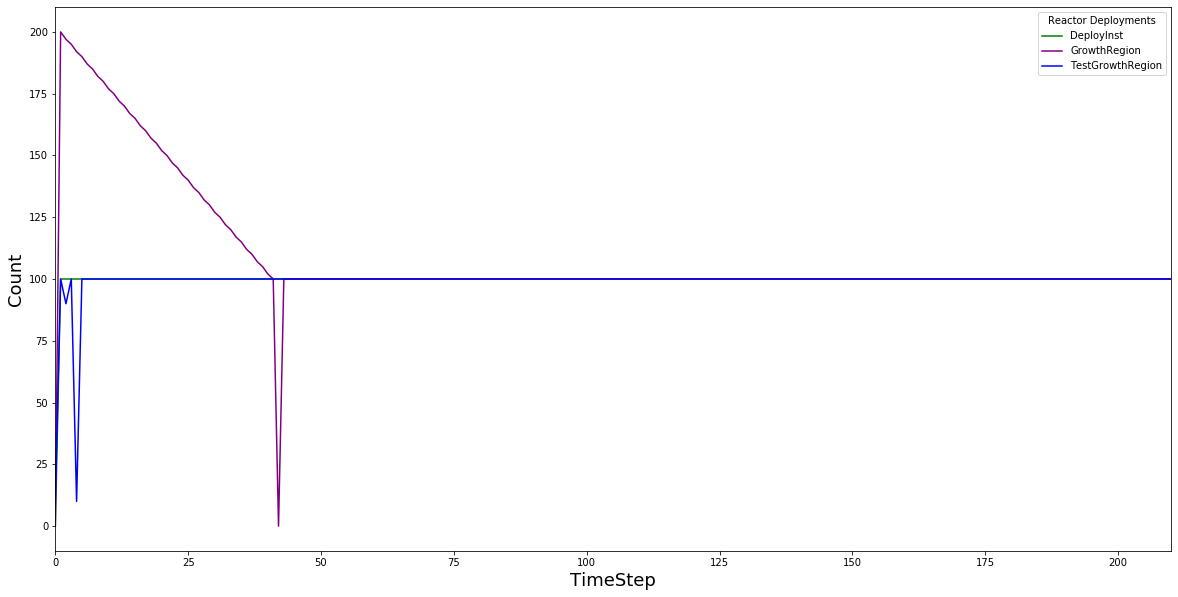

In [45]:
colors = ['green', 'purple']#, 'blue']
ax = plot_df[['TimeStep', 'deploy_total', 'growth_total']].plot(x='TimeStep', figsize=(20,10), \
                                                                legend=False, color=colors)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst')
legend.get_texts()[1].set_text('GrowthRegion')
#legend.get_texts()[2].set_text('TestGrowthRegion')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=18)
plt.ylabel(r'Count',fontsize=18)
#ax.set_ylim(0, 15)
#ax.set_xlim(0, 210)
plt.show()

# Power Steady @ 100 GWe / yr

In [20]:
df_d = evd.eval('TimeSeriesPower')
df_g = evg.eval('TimeSeriesPower')
#df_t = evt.eval('TimeSeriesPower')
# power in GWe
power_d = df_d.groupby(['Time'])['Value'].sum() / 1000.0
power_g = df_g.groupby(['Time'])['Value'].sum() / 1000.0
#power_t = df_t.groupby(['Time'])['Value'].sum() / 1000.0

#power = pd.DataFrame({'deploy_pwr' : power_d, 'growth_pwr' : power_g, 'test_pwr' : power_t}, index=power_d.index).reset_index()
power = pd.DataFrame({'deploy_pwr' : power_d, 'growth_pwr' : power_g}, index=power_d.index).reset_index()

In [21]:
power

,Time,deploy_pwr,growth_pwr
0,1,100.0,100.0
1,2,100.0,100.0
2,3,100.0,100.0
3,4,100.0,100.0
4,5,100.0,100.0
...,...,...,...
1194,1195,100.0,100.0
1195,1196,100.0,100.0
1196,1197,100.0,100.0
1197,1198,100.0,100.0


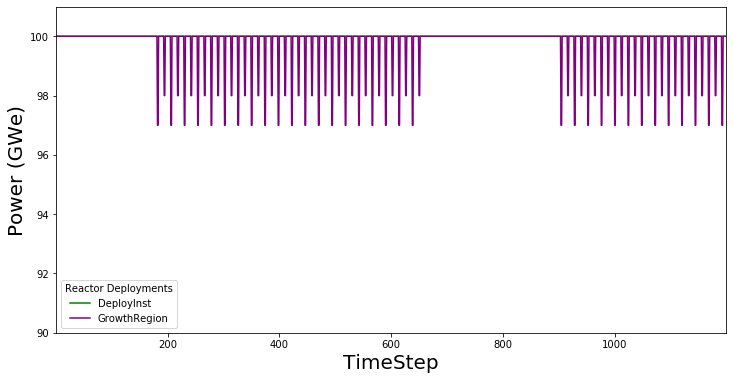

In [32]:
colors = ['green', 'purple']#, 'blue']
ax = power.plot(x='Time', figsize=(12,6), legend=False, color=colors)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst')
legend.get_texts()[1].set_text('GrowthRegion')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=20)
plt.ylabel(r'Power (GWe)',fontsize=20)
ax.set_ylim(90, 101)
plt.show()